# Credit Card Company - Autoencoders 
MSDS 411<Br>
Assignment 3<br>
Prepared by Vincent Pun

In [1]:
library(farff) # for reading arff file
library(cvTools) # explicit creation of folds for cross-validation
library(ModelMetrics) # used for precision-recall evaluation of classifiers
library(car) # for recode function


# optimal cutoff for predicting bad credit set as
# (cost of false negative/cost of false positive) times
# (prevalence of positive/prevalence of negative)

#CUTOFF CLASSIFICATION AND COST MATRIX----
# (1/5)*(.3/.7) = 0.086
CUTOFF = 0.086 #Cutoff Classification 
COSTMATRIX = matrix(c(0,5,1,0), nrow = 2, ncol = 2, byrow = TRUE) #Cost Matrix 

#CREDIT ARFF DATASET----
credit = readARFF("dataset_31_credit-g.arff")

# write to comma-delimited text for review in Excel
write.csv(credit, file = "credit.csv", row.names = FALSE)

# check structure of the data frame
cat("\n\nStucture of initial credit data frame:\n")
print(str(credit))

# quick summary of credit data
cat("\n\nSummary of initial credit data frame:\n")
print(summary(credit))

Loading required package: lattice
Loading required package: robustbase

Attaching package: ‘ModelMetrics’

The following object is masked from ‘package:base’:

    kappa

Loading required package: carData
Parse with reader=readr : dataset_31_credit-g.arff
Loading required package: readr
header: 0.039000; preproc: 0.004000; data: 0.058000; postproc: 0.001000; total: 0.102000




Stucture of initial credit data frame:
'data.frame':	1000 obs. of  21 variables:
 $ checking_status       : Factor w/ 4 levels "<0","0<=X<200",..: 1 2 4 1 1 4 4 2 4 2 ...
 $ duration              : num  6 48 12 42 24 36 24 36 12 30 ...
 $ credit_history        : Factor w/ 5 levels "no credits/all paid",..: 5 3 5 3 4 3 3 3 3 5 ...
 $ purpose               : Factor w/ 11 levels "new car","used car",..: 4 4 7 3 1 7 3 2 4 1 ...
 $ credit_amount         : num  1169 5951 2096 7882 4870 ...
 $ savings_status        : Factor w/ 5 levels "<100","100<=X<500",..: 5 1 1 1 1 5 3 1 4 1 ...
 $ employment            : Factor w/ 5 levels "unemployed","<1",..: 5 3 4 4 3 3 5 3 4 1 ...
 $ installment_commitment: num  4 2 2 2 3 2 3 2 2 4 ...
 $ personal_status       : Factor w/ 5 levels "male div/sep",..: 3 2 3 3 3 3 3 3 1 4 ...
 $ other_parties         : Factor w/ 3 levels "none","co applicant",..: 1 1 1 3 1 1 1 1 1 1 ...
 $ residence_since       : num  4 2 3 4 4 4 4 2 4 2 ...
 $ property_magnitude    :

In [2]:
#DATA PREPARATION ----

# personal_status has level "female single" with no observations
cat("\n\nProblems with personal_status, no single females:\n")
print(table(credit$personal_status))

# fix this prior to analysis
#level 5 (female single) has NO OBSERVATIONS in this study, so REMOVE 
credit$personal_status = factor(as.numeric(credit$personal_status),
    levels = c(1,2,3,4), 
    labels = c("male div/sep","female div/dep/mar","male single","male mar/wid"))



Problems with personal_status, no single females:

      male div/sep female div/dep/mar        male single       male mar/wid 
                50                310                548                 92 
     female single 
                 0 


In [3]:
#Purpose, low and no end frequency levels
cat("\n\nProblems with purpose, low- and no-frequency levels:\n")
print(table(credit$purpose))
# keep first four classes: "new car", "used car", "furniture/equipment", "radio/tv"
#Classes with low frequency, collapse these into the "other" classificaiton
# keep "education" and "business" with new values 
# add "retraining" to "education"
# gather all other levels into "other"
credit$purpose = recode(credit$purpose, '"new car" = "new car";
    "used car" = "used car"; 
    "furniture/equipment" = "furniture/equipment";
    "radio/tv" = "radio/tv"; 
    "education" = "education"; "retraining" = "education";
    "business" = "business"; 
    "domestic appliance" = "other"; "repairs" = "other"; "vacation" = "other"; 
    "other" = "other" ',
    levels = c("new car","used car","furniture/equipment","radio/tv", 
    "education","business","other" ))



Problems with purpose, low- and no-frequency levels:

            new car            used car furniture/equipment            radio/tv 
                234                 103                 181                 280 
 domestic appliance             repairs           education            vacation 
                 12                  22                  50                   0 
         retraining            business               other 
                  9                  97                  12 


In [4]:
# credit_amount is highly skewed... use log_credit_amount instead
credit$log_credit_amount = log(credit$credit_amount)    

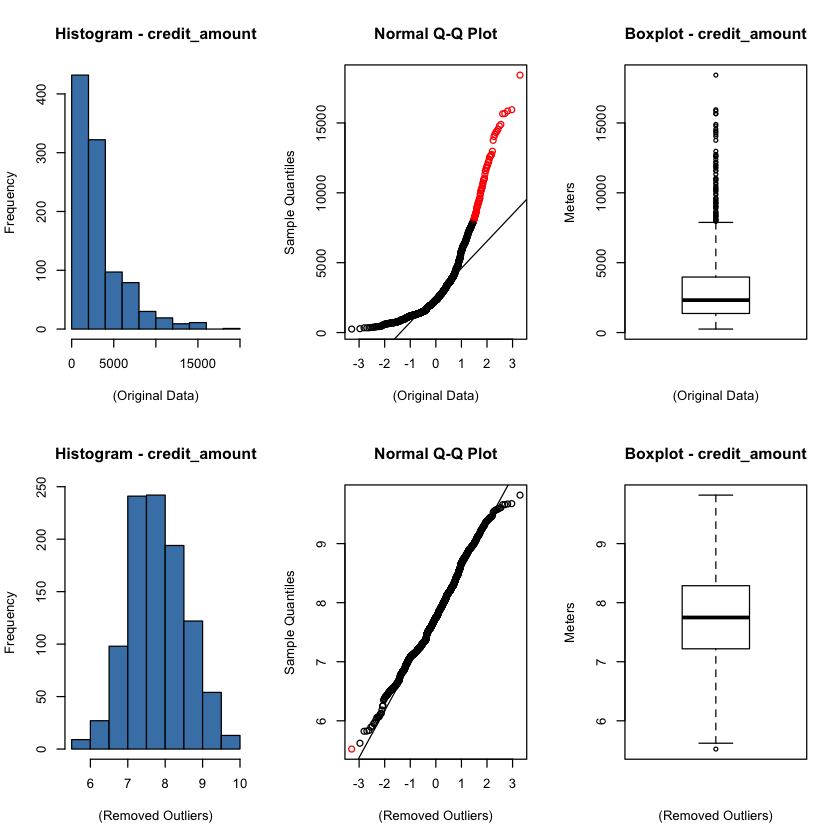

In [5]:
#PARAMETERS ----

par(mfrow = c(2,3))


#######----ORIGINAL DATA----#########
#histogram
hist(credit$credit_amount,
     main = "Histogram - credit_amount",
     xlab = "(Original Data)",
     col = "steelblue")

#qqplot 
qqnorm(credit$credit_amount,
       col = ifelse(credit$credit_amount %in% 
                      c(boxplot.stats(credit$credit_amount)$out), #red for outliers
                    "red","black"),
       xlab = "(Original Data)")

qqline(credit$credit_amount)

#boxplot
boxplot(credit$credit_amount,
        main = "Boxplot - credit_amount",
        ylab = "Meters",
        xlab = "(Original Data)")

#######----NO OUTLIERS----#########

#histogram
hist(credit$log_credit_amount,
     main = "Histogram - credit_amount",
     xlab = "(Removed Outliers)",
     col = "steelblue")

#qqplot 
qqnorm(credit$log_credit_amount,
       col = ifelse(credit$log_credit_amount %in% 
                      c(boxplot.stats(credit$log_credit_amount)$out), #red for outliers
                    "red","black"),
       xlab = "(Removed Outliers)")

qqline(credit$log_credit_amount)

#boxplot
boxplot(credit$log_credit_amount,
        main = "Boxplot - credit_amount",
        ylab = "Meters",
        xlab = "(Removed Outliers)")


In [6]:
#Purpose, low and no end frequency levels
cat("\n\nProblems with purpose, low- and no-frequency levels:\n")
print(table(credit$purpose))
# keep first four classes: "new car", "used car", "furniture/equipment", "radio/tv"
#Classes with low frequency, collapse these into the "other" classificaiton
# keep "education" and "business" with new values 
# add "retraining" to "education"
# gather all other levels into "other"
credit$purpose = recode(credit$purpose, '"new car" = "new car";
    "used car" = "used car"; 
    "furniture/equipment" = "furniture/equipment";
    "radio/tv" = "radio/tv"; 
    "education" = "education"; "retraining" = "education";
    "business" = "business"; 
    "domestic appliance" = "other"; "repairs" = "other"; "vacation" = "other"; 
    "other" = "other" ',
    levels = c("new car","used car","furniture/equipment","radio/tv", 
    "education","business","other" ))



Problems with purpose, low- and no-frequency levels:

            new car            used car furniture/equipment            radio/tv 
                234                 103                 181                 280 
          education            business               other 
                 59                  97                  46 


In [7]:
# summary of transformed credit data
cat("\n\nSummary of revised credit data frame:\n")
print(summary(credit))



Summary of revised credit data frame:
    checking_status    duration                           credit_history
 <0         :274    Min.   : 4.0   no credits/all paid           : 40   
 0<=X<200   :269    1st Qu.:12.0   all paid                      : 49   
 >=200      : 63    Median :18.0   existing paid                 :530   
 no checking:394    Mean   :20.9   delayed previously            : 88   
                    3rd Qu.:24.0   critical/other existing credit:293   
                    Max.   :72.0                                        
                                                                        
                purpose    credit_amount            savings_status
 new car            :234   Min.   :  250   <100            :603   
 used car           :103   1st Qu.: 1366   100<=X<500      :103   
 furniture/equipment:181   Median : 2320   500<=X<1000     : 63   
 radio/tv           :280   Mean   : 3271   >=1000          : 48   
 education          : 59   3rd Qu.: 3972 

Baseline Logistic Regression

In [8]:
# logistic regression evaluated with cross-validation

# include explanatory variables except foreign_worker
# (only 37 of 100 cases are foreign workers)
credit_model = "class ~ checking_status + duration + 
    credit_history + purpose + log_credit_amount + savings_status + 
    employment + installment_commitment + personal_status +        
    other_parties + residence_since + property_magnitude +
    age + other_payment_plans + housing + existing_credits +      
    job + num_dependents + own_telephone" 

#cross validation folds, 5 fold cross validation
set.seed(1)
nfolds = 5
folds = cvFolds(nrow(credit), K = nfolds) # creates list of indices

#compute precision, recall, f1 score, and cost ----
#BASE (0 cutoff)
baseprecision = rep(0, nfolds)  # precision with 0 cutoff
baserecall = rep(0, nfolds)  # recall with  0 cutoff
basef1Score = rep(0, nfolds)  # f1Score with 0 cutoff
basecost = rep(0, nfolds)  # total cost with 0 cutoff

#CUTOFF
ruleprecision = rep(0, nfolds)  # precision with CUTOFF rule
rulerecall = rep(0, nfolds)  # recall with CUTOFF rule
rulef1Score = rep(0, nfolds)  # f1Score with CUTOFF rule
rulecost = rep(0, nfolds)  # total cost with CUTOFF rule

#looping, each fold, compute statistics for evaluating accuracy of cross validation and evaluate costs 
for (ifold in seq(nfolds)) {
    # cat("\n\nSUMMARY FOR IFOLD:", ifold) # checking in development
    # print(summary(credit[(folds$which == ifold),]))
  
    # train model on all folds except ifold
    train = credit[(folds$which != ifold), ]
    
    #test
    test = credit[(folds$which == ifold),]
    
    #logistic model
    credit_fit = glm(credit_model, family = binomial,
        data = train)
    
    # evaluate on fold ifold    
    # predict on test 
    credit_predict = predict.glm(credit_fit, 
        newdata = test, type = "response") 
    
    #BASE 
    #CUTOFF = 0.5 
    #precision, recall, f1score, confusion matrix
    #ppv = positive predictive value)
    #subtract 1 because as.numeric changes good and bad to 1 and 2 respectively 
    baseprecision[ifold] = ppv(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5)  
    baserecall[ifold] = recall(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5) 
    basef1Score[ifold] = f1Score(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5) 
    basecost[ifold] = sum(
        confusionMatrix(as.numeric(test$class)-1,
        credit_predict) * COSTMATRIX)  
    
    #CUTOFF
    #precision, recall, f1Score, confusionMatrix
    #ppv = positive predictive value)
    #subtract 1 because as.numeric changes good and bad to 1 and 2 respectively 
    ruleprecision[ifold] = ppv(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF)  
    rulerecall[ifold] = recall(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF) 
    rulef1Score[ifold] = f1Score(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF)
    rulecost[ifold] = sum(
        confusionMatrix(as.numeric(test$class)-1, 
            credit_predict,cutoff=CUTOFF) * COSTMATRIX)                                    
} 

#cvbaseline----
#collect values
cvbaseline = data.frame(baseprecision, baserecall, basef1Score, basecost,
                        ruleprecision, rulerecall, rulef1Score, rulecost)

In [9]:
cat("\n\nCross-validation summary across folds:\n")
print(round(cvbaseline, digits = 3))



Cross-validation summary across folds:
  baseprecision baserecall basef1Score basecost ruleprecision rulerecall
1         0.538      0.475       0.505      179         0.362      0.864
2         0.607      0.557       0.581      157         0.418      0.967
3         0.592      0.509       0.547      160         0.338      0.930
4         0.609      0.475       0.533      173         0.372      0.932
5         0.652      0.469       0.545      186         0.381      0.922
  rulef1Score rulecost
1       0.510      130
2       0.584       92
3       0.495      124
4       0.531      113
5       0.539      121



The F-score, also called the F1-score, is a measure of a model's accuracy on a dataset. ... The F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model's precision and recall.

That is, a good F1 score means that you have low false positives and low false negatives, so you're correctly identifying real threats and you are not disturbed by false alarms. An F1 score is considered perfect when it's 1 , while the model is a total failure when it's 0 

cost information and knowledge of prevelance of bad = cutoff rules 


The F1 Score is the 2*((precision*recall)/(precision+recall)).

In [10]:
cat("\n\nCross-validation baseline results under STANDARD cutoff rules:")
cat("\n    F1 Score: ", round(mean(cvbaseline$basef1Score), digits = 3))
cat("\n    Average cost per fold: ", 
    round(mean(cvbaseline$basecost), digits = 2), "\n")
cat("\n    Average precision per fold: ", 
    round(mean(cvbaseline$baseprecision), digits = 2), "\n")
cat("\n    Average recall per fold: ", 
    round(mean(cvbaseline$baserecall), digits = 2), "\n")

cat("\n\nCross-validation baseline results under cost cutoff rules:")
cat("\n    F1 Score: ", round(mean(cvbaseline$rulef1Score), digits = 3))
cat("\n    Average cost per fold: ", 
    round(mean(cvbaseline$rulecost), digits = 2), "\n")
cat("\n    Average precision per fold: ", 
    round(mean(cvbaseline$ruleprecision), digits = 2), "\n")
cat("\n    Average recall per fold: ", 
    round(mean(cvbaseline$rulerecall), digits = 2), "\n")



Cross-validation baseline results under STANDARD cutoff rules:
    F1 Score:  0.542
    Average cost per fold:  171 

    Average precision per fold:  0.6 

    Average recall per fold:  0.5 


Cross-validation baseline results under cost cutoff rules:
    F1 Score:  0.532
    Average cost per fold:  116 

    Average precision per fold:  0.37 

    Average recall per fold:  0.92 


Prepare data for autoencoder
Normmalize

credit_model = "class ~ checking_status + duration + 
    credit_history + purpose + log_credit_amount + savings_status + 
    employment + installment_commitment + personal_status +        
    other_parties + residence_since + property_magnitude +
    age + other_payment_plans + housing + existing_credits +      
    job + num_dependents + own_telephone" 

In [11]:
# prepare data for input to autoencoder work
#make it into a matrix so that dummy variables become binary
design_matrix = model.matrix(as.formula(credit_model), data = credit)
design_data_frame = as.data.frame(design_matrix)[,-1]  # dropping the intercept term

# normalize the data ----
minmaxnorm <- function(x) { return ((x - min(x)) / (max(x) - min(x))) }


#minmax_data_frame
minmax_data_frame <- as.data.frame(lapply(design_data_frame, FUN = minmaxnorm)) #as.data.frame (CHANGE)

cat("\n\nStructure of minmax_data_frame for input to autoencoding work:\n")
print(str(minmax_data_frame))

dim(credit) #1000 x 22
dim(design_data_frame) #1000 x 44 
dim(minmax_data_frame)#1000 x 44 



Structure of minmax_data_frame for input to autoencoding work:
'data.frame':	1000 obs. of  44 variables:
 $ checking_status0..X.200                     : num  0 1 0 0 0 0 0 1 0 1 ...
 $ checking_status..200                        : num  0 0 0 0 0 0 0 0 0 0 ...
 $ checking_statusno.checking                  : num  0 0 1 0 0 1 1 0 1 0 ...
 $ duration                                    : num  0.0294 0.6471 0.1176 0.5588 0.2941 ...
 $ credit_historyall.paid                      : num  0 0 0 0 0 0 0 0 0 0 ...
 $ credit_historyexisting.paid                 : num  0 1 0 1 0 1 1 1 1 0 ...
 $ credit_historydelayed.previously            : num  0 0 0 0 1 0 0 0 0 0 ...
 $ credit_historycritical.other.existing.credit: num  1 0 1 0 0 0 0 0 0 1 ...
 $ purposeused.car                             : num  0 0 0 0 0 0 0 1 0 0 ...
 $ purposefurniture.equipment                  : num  0 0 0 1 0 0 1 0 0 0 ...
 $ purposeradio.tv                             : num  1 1 0 0 0 0 0 0 1 0 ...
 $ purposeeducation 

[1] 1000   22

[1] 1000   44

[1] 1000   44

In [12]:
# Autoencoder
###########################
# Resources
###########################
# https://blogs.rstudio.com/tensorflow/posts/2018-01-24-keras-fraud-autoencoder/ (Links to an external site.)

library(tidyr)
library(dplyr)
library(ggplot2)
library(ggridges)
library(keras)
library(pROC)

library(reshape2)

###########################
# Helper functions
###########################

# normalize using the min-max method
normalize <- function(x) {
  denom <- ifelse(max(x) - min(x) == 0, 1, max(x) - min(x))
  return ((x - min(x)) / denom)
}


Attaching package: ‘dplyr’

The following object is masked from ‘package:car’:

    recode

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following object is masked from ‘package:ModelMetrics’:

    auc

The following objects are masked from ‘package:stats’:

    cov, smooth, var


Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



Warning message:
“attributes are not identical across measure variables;
they will be dropped”Picking joint bandwidth of 0.0239


 checking_status0..X.200 checking_status..200 checking_statusno.checking
 Min.   :0.000           Min.   :0.000        Min.   :0.000             
 1st Qu.:0.000           1st Qu.:0.000        1st Qu.:0.000             
 Median :0.000           Median :0.000        Median :0.000             
 Mean   :0.269           Mean   :0.063        Mean   :0.394             
 3rd Qu.:1.000           3rd Qu.:0.000        3rd Qu.:1.000             
 Max.   :1.000           Max.   :1.000        Max.   :1.000             
    duration      credit_historyall.paid credit_historyexisting.paid
 Min.   :0.0000   Min.   :0.000          Min.   :0.00               
 1st Qu.:0.1176   1st Qu.:0.000          1st Qu.:0.00               
 Median :0.2059   Median :0.000          Median :1.00               
 Mean   :0.2486   Mean   :0.049          Mean   :0.53               
 3rd Qu.:0.2941   3rd Qu.:0.000          3rd Qu.:1.00               
 Max.   :1.0000   Max.   :1.000          Max.   :1.00               
 credi

class,Count
good,700
bad,300


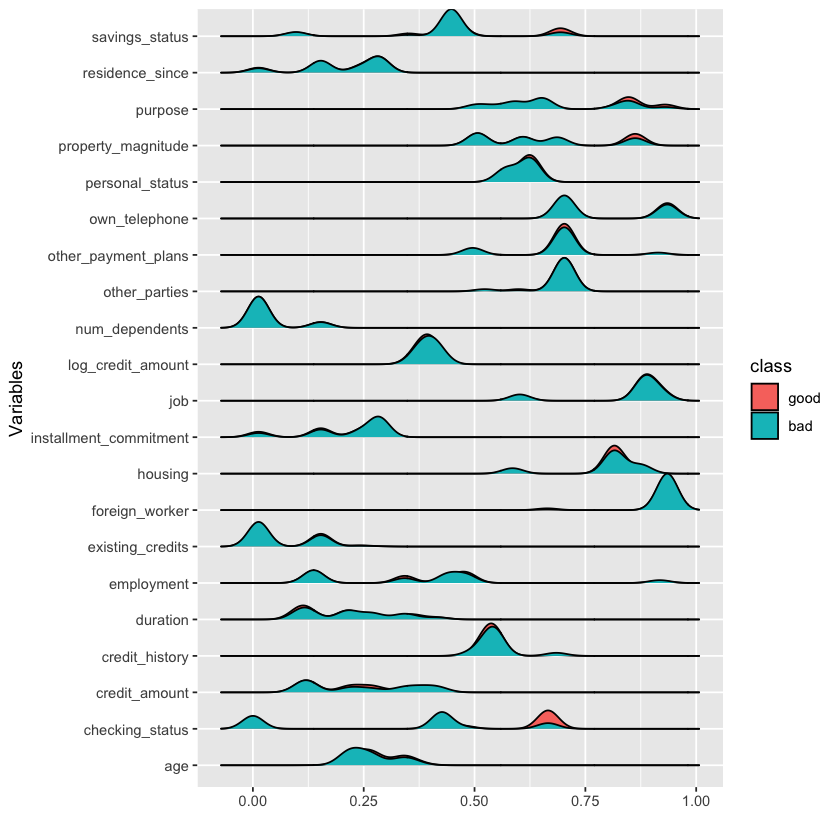

In [13]:
###########################
# Exploratory Data Analysis
# Data Prep
###########################

credit %>%
        gather(variable, value, -class) %>%
        ggplot(aes(y = as.factor(variable),
                   fill = as.factor(class),
                   x = percent_rank(value)))+
        geom_density_ridges(scale = 1) +
        labs(fill = 'class', y = 'Variables', x = '')


# Review range of variables and ensure no N/As exist
summary(minmax_data_frame)

# Check to see if dataset is balanced
#700 to 300 
credit %>%
        group_by(class) %>%
        summarize(Count = n())


In [14]:
###########################
# Split the dataset
###########################

## set the seed to make your partition reproducible
set.seed(123)

#sample size
smp_size <- floor(0.80 * nrow(minmax_data_frame))

train_ind <- sample(seq_len(nrow(minmax_data_frame)), size = smp_size)

#df_train and df_test
df_train <- minmax_data_frame[train_ind, ]
df_test <- minmax_data_frame[-train_ind, ]

#y_train and y_test
y_train <- credit$class[train_ind]
y_test <- credit$class[-train_ind]

# Create the training matrix
x_train <- df_train %>%
  as.matrix()

# Create the testing matrix
x_test <- df_test %>%
  as.matrix()

Now that the data has been prepared, we can start building the model. The keras::sequential model is the most common model type. It is defined as a sequential stack of layers. To build a model, we must first instantiate a sequential object then add layers so the model knows shape of data for each layer. 

The ‘layer_dense’ specifies a layer of neurons where each neuron receives input from the neurons in the previous layer.  Note that the first layer has the additional parameter ‘input_shape’. This tells the model that the input will contain 44 variables. 

The ‘units’ parameter specifies the number of neurons or dimensionality of the outspace. So, in the first layer, also known as the input layer, we input 44 variables and reduce its dimensionality to 15 units. Next, we have a hidden layer with that accepts an input of 15 units and reduces the dimensionality to 10 units. These two layers make up the encoder.

The decoder consists of the two remaining layers. Recall that the decoder attempts to reconstruct the input, so here the first layer of the decoder takes an input of 10 units and decompresses it to 15 units. The final layer, also known as the output layer, should always have the same shape of the input layer. This layer takes an input of 15 units and further decompresses it to dimensionality of the original 44 variables.

Except for the output layer, each layer has an activation function specified. For our model, we use the Tanh activation function. The Tanh function is bound to the range (-1, 1). 

The purpose of the activation function is to tell the following layers if the neuron is activated or not.  Other activation functions may be suitable for this task as well and you are free to experiment.

In [15]:
ncol(x_train)

[1] 44

**Model  1**

In [16]:
###########################
# MODEL 1 - AUTOENCODER
###########################

###########################
# Construct and compile the autoencoder
###########################

# Create a sequential model
model <- keras_model_sequential()
model %>%
  # encoder
  layer_dense(units = 15, activation = "tanh", input_shape = ncol(x_train)) %>%
  layer_dense(units = 10, activation = "tanh") %>%
  # decoder
  layer_dense(units = 15, activation = "tanh") %>%
  layer_dense(units = ncol(x_train)
)

# Compile the modelminmax_data_frame
model %>% compile(
  loss='mean_squared_error',
  optimizer='adam',
  metrics = c('accuracy')
)

# View the model summary
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense (Dense)                       (None, 15)                      675         
________________________________________________________________________________
dense_1 (Dense)                     (None, 10)                      160         
________________________________________________________________________________
dense_2 (Dense)                     (None, 15)                      165         
________________________________________________________________________________
dense_3 (Dense)                     (None, 44)                      704         
Total params: 1,704
Trainable params: 1,704
Non-trainable params: 0
________________________________________________________________________________


**Model  2 and 2b**

In [17]:
###########################
# MODEL 2 - AUTOENCODER
###########################

###########################
# Construct and compile the autoencoder
###########################

# Create a sequential model
model2 <- keras_model_sequential()
model2 %>%
  # encoder
  layer_dense(units = 30, activation = "tanh", input_shape = ncol(x_train)) %>%
  layer_dense(units = 20, activation = "tanh") %>%
  layer_dense(units = 10, activation = "tanh") %>%
  # decoder
  layer_dense(units = 20, activation = "tanh") %>%
  layer_dense(units = 30, activation = "tanh") %>%
  layer_dense(units = ncol(x_train)
)

# Compile the model
model2 %>% compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics = c('accuracy')
)

# View the model summary
summary(model2)

# Create a sequential model
model2b <- keras_model_sequential()
model2b %>%
  # encoder
  layer_dense(units = 30, activation = "tanh", input_shape = ncol(x_train)) %>%
  layer_dense(units = 20, activation = "tanh") %>%
  layer_dense(units = 10, activation = "tanh") %>%
  # decoder
  layer_dense(units = 20, activation = "tanh") %>%
  layer_dense(units = 30, activation = "tanh") %>%
  layer_dense(units = ncol(x_train)
)

# Compile the model
model2b %>% compile(
  loss='mean_squared_error',
  optimizer='adam',
  metrics = c('accuracy')
)

# View the model summary
summary(model2b)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_4 (Dense)                     (None, 30)                      1350        
________________________________________________________________________________
dense_5 (Dense)                     (None, 20)                      620         
________________________________________________________________________________
dense_6 (Dense)                     (None, 10)                      210         
________________________________________________________________________________
dense_7 (Dense)                     (None, 20)                      220         
________________________________________________________________________________
dense_8 (Dense)                     (None, 30)                      630         
________________________________________________________________________________
dense_9 (Dense)             

**Model  3**

In [18]:
###########################
# MODEL 3 - AUTOENCODER
###########################

###########################
# Construct and compile the autoencoder
###########################

# Create a sequential model
model3 <- keras_model_sequential()
model3 %>%
  # encoder
  layer_dense(units = 30, activation = "tanh", input_shape = ncol(x_train)) %>%
  layer_dense(units = 20, activation = "tanh") %>%
  layer_dense(units = 10, activation = "tanh") %>%
  # decoder
  layer_dense(units = 20, activation = "tanh") %>%
  layer_dense(units = 30, activation = "tanh") %>%
  layer_dense(units = ncol(x_train)
)

# Compile the model
model3 %>% compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics = c('accuracy')
)

# View the model summary
summary(model3)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_16 (Dense)                    (None, 30)                      1350        
________________________________________________________________________________
dense_17 (Dense)                    (None, 20)                      620         
________________________________________________________________________________
dense_18 (Dense)                    (None, 10)                      210         
________________________________________________________________________________
dense_19 (Dense)                    (None, 20)                      220         
________________________________________________________________________________
dense_20 (Dense)                    (None, 30)                      630         
________________________________________________________________________________
dense_21 (Dense)            

We are now ready to fit our model. We do so by calling the ‘fit’ function from the keras package. Something unique about autoencoders is that we pass the same dataset for x and y. This makes sense since we are goal is to encode the data then reconstruct it. We do the same for our validation data, which is used to determine how well the reconstructed data matches the original inputs.

The two callback functions that are used here are only for convenience. The first, ‘checkpoint’ tracks the training progress and saves a copy of the best model. The ‘early_stopping’ callback is used to halt training if the validation loss stops improving for five epochs since no further improvement is expected. 

In [19]:
###########################
# Fit the model
# Save the best model
###########################

# Save the best model
checkpoint <- callback_model_checkpoint(
  filepath = "model.hdf5",
  save_best_only = TRUE,
  period = 1,
  verbose = 1
)

#
checkpoint2 <- callback_model_checkpoint(
  filepath = "model2.hdf5",
  save_best_only = TRUE,
  period = 1,
  verbose = 1
)

#creating embedding input for logistic regression
checkpoint2b <- callback_model_checkpoint(
  filepath = "model2b.hdf5",
  save_best_only = TRUE,
  period = 1,
  verbose = 1
)

checkpoint3 <- callback_model_checkpoint(
  filepath = "model3.hdf5",
  save_best_only = TRUE,
  period = 1,
  verbose = 1
)

# Stop training if val_loss stops decreasing
early_stopping <- callback_early_stopping(monitor = 'val_loss', patience = 5)



Warning message in callback_model_checkpoint(filepath = "model.hdf5", save_best_only = TRUE, :
“The save_freq argument is only used by TensorFlow >= 1.14. Update TensorFlow or use save_freq = NULL”Warning message in callback_model_checkpoint(filepath = "model2.hdf5", save_best_only = TRUE, :
“The save_freq argument is only used by TensorFlow >= 1.14. Update TensorFlow or use save_freq = NULL”Warning message in callback_model_checkpoint(filepath = "model2b.hdf5", save_best_only = TRUE, :
“The save_freq argument is only used by TensorFlow >= 1.14. Update TensorFlow or use save_freq = NULL”Warning message in callback_model_checkpoint(filepath = "model3.hdf5", save_best_only = TRUE, :
“The save_freq argument is only used by TensorFlow >= 1.14. Update TensorFlow or use save_freq = NULL”

**Fit Model 1**

In [20]:
#0 = good
#1 = bad
y_train <- as.numeric(y_train)-1
y_test <- as.numeric(y_test)-1

We are only training on non-fraudulent transactions (y_train == 0). Since our autoencoder is trained to reconstruct good credit transactions, the reconstruction error on bad credit transactions should be much higher. We can use this higher reconstruction error to identify bad credit customers.

In [21]:
# Train the model
model %>% fit(
  x = x_train,
  y = x_train,
  epochs = 100,
  batch_size = 32,
  validation_data = list(x_test, x_test),
  callbacks = list(checkpoint, early_stopping)
)


In [22]:
# Check the loss
loss <- evaluate(model, x = x_test[y_test == 0,], y = x_test[y_test == 0,])
loss

$loss
[1] 0.05707349

$acc
[1] 0.06153846

**Fit Model 2**

In [23]:
# Train the model ()
model2 %>% fit(
  x = x_train[y_train == 0,],
  y = x_train[y_train == 0,],
  epochs = 100,
  batch_size = 32,
  validation_data = list(x_test[y_test == 0,], x_test[y_test == 0,]),
  callbacks = list(checkpoint2, early_stopping)
)


In [24]:
# Train the model
model2b %>% fit(
  x = x_train,
  y = x_train,
  epochs = 100,
  batch_size = 32,
  validation_data = list(x_test, x_test),
  callbacks = list(checkpoint2b, early_stopping)
)


**Fit Model 3**

In [25]:
# Train the model
model3 %>% fit(
  x = x_train,
  y = x_train,
  epochs = 100,
  batch_size = 32,
  validation_data = list(x_test, x_test),
  callbacks = list(checkpoint3, early_stopping)
)


Recall that the best model was saved during training. We can now reload the saved model and use it for the remainder of the lab. This step is not necessary, but it is useful to know how to save and load models for later use. 

In order to detect bad credit, we need to determine the mean squared error (MSE) for each observation. 

We accomplish this by passing the full training and test sets into the ‘predict’ function from the keras package.  

Since our model is an autoencoder, predicting on the dataset will basically encode and then reconstruct the data. 

**Predictions Model 2**

In [26]:
###########################
# Load the saved model
# Calculate MSE
###########################

# Load the saved model
model2 <- load_model_hdf5("model2.hdf5", compile = FALSE)

# Reconstruct the training set and calculate MSE
pred_train2 <- predict(model2, x_train)
MSE_train2 <- apply((x_train - pred_train2) ^2, 1, sum)

# Reconstruct the test set and calculate MSE
pred_test2 <- predict(model2, x_test)
MSE_test2 <- apply((x_test - pred_test2) ^2, 1, sum)

Area Under the Curve (AUC) and Receiver Operating Characteristics (ROC) curve are useful measurements for classification problems.  

The AUC is a measure of how well the model is capable of distinguishing between classes.  The higher the AUC, the better.  The ROC curve is a probability plot with the true positive rate (recall) on the y-axis and the false positive rate (ratio of negative instances that are incorrectly classified as positive) on the x-axis. 

Hands on ML Page 91

We were not concerned with accuracy while the model was training, but now we do need to get an idea of how well our model will perform for prediction.  

ROC curve plots and the AUC for both the reconstructed training set and test set are shown below.  With AUCs at 60%, the model appears to be performing quite poorly.  

One thing to note however is that ROC curves do not often perform well with imbalanced datasets.  Our dataset consists of only 300 or 30% bad credit instances so the dataset is imbalanced.

**Using Model 2 (Unsupervised Learning Solution)**

Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


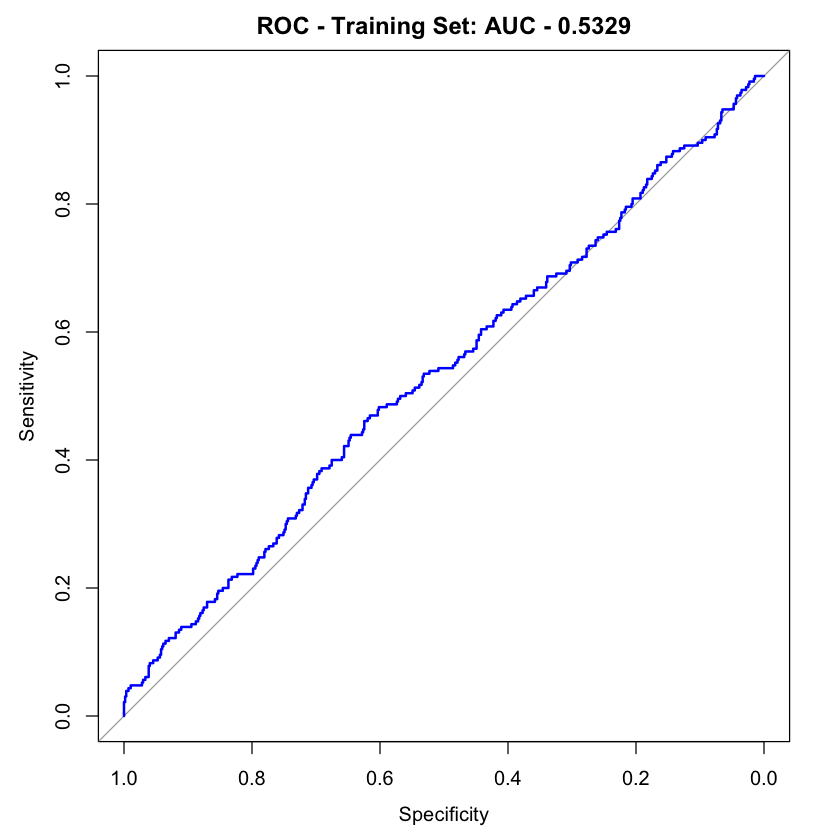

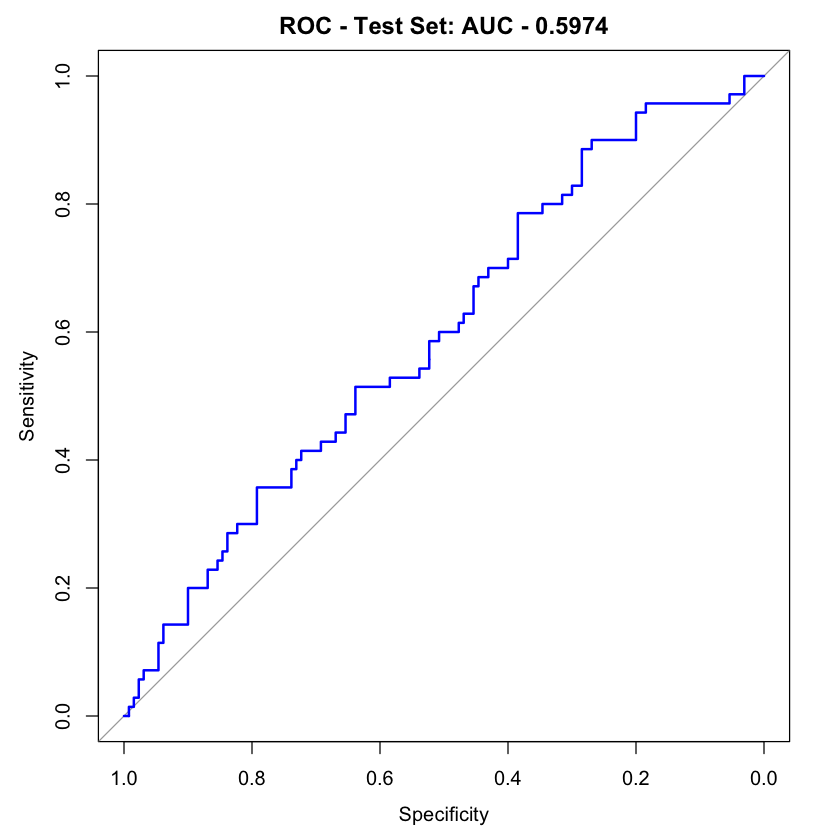

In [27]:
###########################
# AUC and ROC plots
###########################

# Calculate area under the curve and plot the ROC
train_roc <- roc(y_train, MSE_train2)
plot(train_roc, col = "blue", main = paste0("ROC - Training Set: AUC - ", round(train_roc$auc, 4)))

# Calculate area under the curve and plot the ROC
test_roc <- roc(y_test, MSE_test2)
plot(test_roc, col = "blue", main = paste0("ROC - Test Set: AUC - ", round(test_roc$auc, 4)))

Warning message:
“The `x` argument of `as_tibble.matrix()` must have unique column names if `.name_repair` is omitted as of tibble 2.0.0.
Using compatibility `.name_repair`.
This warning is displayed once every 8 hours.
Call `lifecycle::last_warnings()` to see where this warning was generated.”

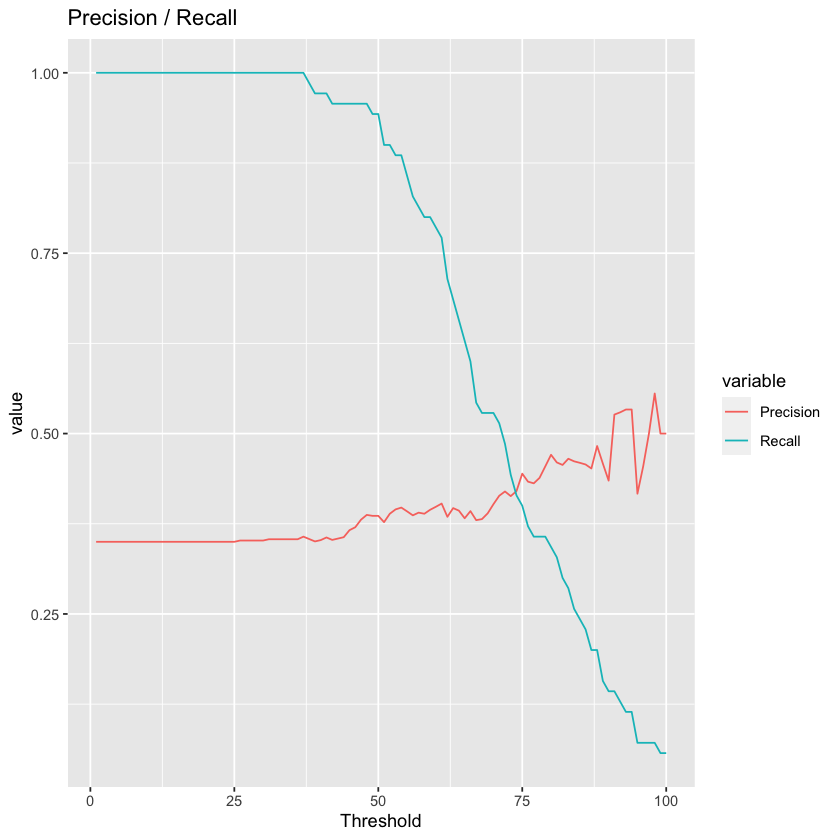

In [28]:
###########################
# Recall and precision
###########################
# Calculate the precision

#MSE BETWEEN 0 AND 8
possible_k <- seq(0,8, length.out = 100)

precision <- sapply(possible_k, function(k) {
    
  predicted_class <- as.numeric(MSE_test2 > k)
    
  sum(predicted_class == 1 & y_test == 1)/sum(predicted_class)
    
})

# Calculate the recall
recall <- sapply(possible_k, function(k) {
  predicted_class <- as.numeric(MSE_test2 > k)
  sum(predicted_class == 1 & y_test == 1)/sum(y_test)
})

# Create dataset for plotting
evaluation <- cbind(seq(1:100), precision, recall) %>%
  as_tibble()
colnames(evaluation) <- c('Threshold', 'Precision', 'Recall')
evaluation <- melt(evaluation, id = 'Threshold')

# Plot precision and recall
ggplot() +
  geom_line(data = evaluation, aes(x = Threshold, y = value, colour = variable)) +
  labs(title = 'Precision / Recall')

Precision and recall are also useful measurements for classification models.  

Precision measures the relevancy of obtained results, while recall measures how many relevant results are returned. Both values can take values between 0 and 1.  

Precision = True positive / (true positive + false positive)

Recall = True Positive / (true positive + false negatives)

We can see that as the reconstruction error or MSE rises the precision rises.  
The opposite is true for recall since recall decreases as MSE rises.

The F1 Score is the 2*((precision*recall)/(precision+recall)).

In [29]:
CUTOFF
COSTMATRIX

[1] 0.086

0,5
1,0


tp fp <br>
fn tn 

In [30]:
as.data.frame(y_test) %>%
        group_by(y_test) %>%
        summarize(Count = n())

y_test,Count
0,130
1,70


In [31]:
###########################
# Fraudulent transactions
###########################

bc <- replicate(length(y_test), 0)
bc[which(MSE_test2 >= 3.2)] <- 1

# Create confusion matrix
confusionMatrix(y_test, bc)
sum(confusionMatrix(y_test,bc)*COSTMATRIX)

7,2
123,68


[1] 133

In [32]:
combdata <- as.data.frame(cbind(y_test, MSE_test2))
head(combdata, n = 5)

,y_test,MSE_test2
1,0,5.469693
3,0,5.300128
7,0,6.541562
9,0,5.641150
12,1,5.778473


[1] "5.27828622785367"

[1] "5.75821726880333"

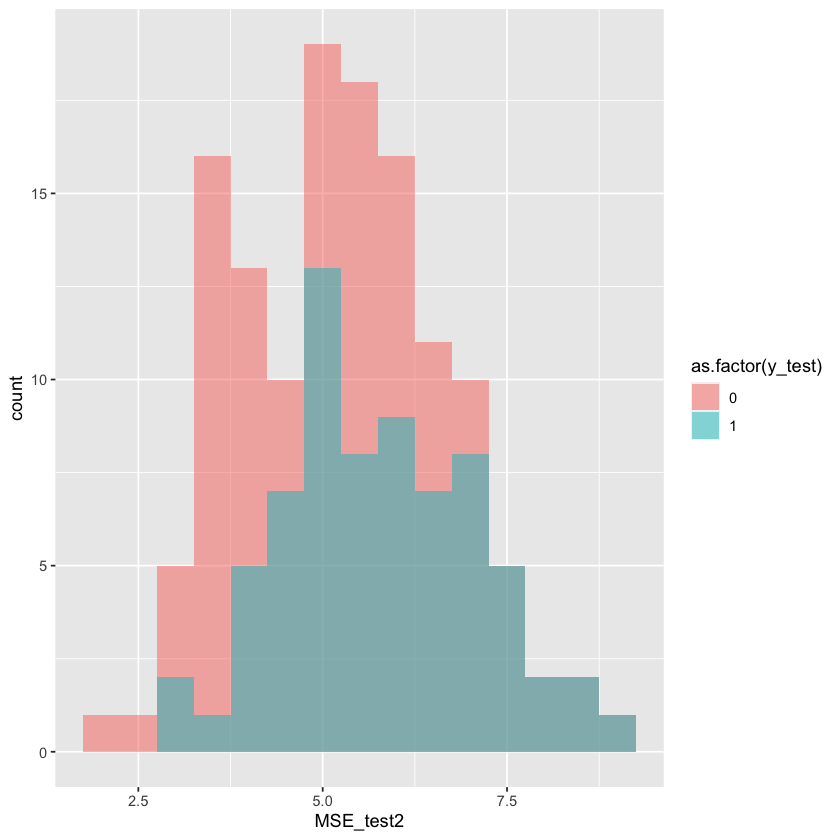

In [33]:
paste(mean(combdata$MSE_test2[combdata$y_test == 0]))
paste(mean(combdata$MSE_test2[combdata$y_test == 1]))


ggplot(combdata, aes(x = MSE_test2, fill = as.factor(y_test)))+
       geom_histogram(binwidth = 0.5, alpha = 0.5, position = "identity")

Recall that only good credit was used to train the model.  When we called the ‘predict’ function to reconstruct the datasets, all transactions were used.  

That means that our model saw bad credit for the first time.  

Our assumption is that these bad credit instances will have a higher reconstruction error rate or MSE.  

So, there should be a threshold we can use to separate the bad credit from the good credit transactions.  

After a manual review of the data, we will set the MSE threshold at _____.  

Any transaction with an MSE of ______ or greater will be flagged as bad credit.

Model identifies: (20% Test Subset)
Good credit __ / 130
Bad credit __ / 70

That may not seem so impressive coming from a neural network, but if you consider that only 30% of observations are bad credit, you quickly realize how impressive the model’s performance actually is.  

With a threshold set at _, we incorrectly classify _ records as bad credit when they are not.  

That may or may not be acceptable.  
It would likely depend on the cost of investigating such cases compared to the loss from fraudulent transactions.  

By adjusting the threshold to meet the business needs, we could **minimize the false positives.**



In [34]:
################################################################################################

**Autoencoder 1 - Generate Embedding**

In [35]:
#Autoencoder 1 - Generate Embedding----

#The Combined Model, Generate Embedding
minmax_data_frame_train <- minmax_data_frame %>%
  as.matrix()

pred_all <- predict(model, minmax_data_frame_train)

pred_all <- as.data.frame(pred_all)

#bind with credit class
credit2 <- cbind(credit$class, pred_all)

#change column name
colnames(credit2)[1] <- c("class")

names(credit2)
head(credit2)
dim(credit)
dim(credit2)

[1] "class" "V1"    "V2"    "V3"    "V4"    "V5"    "V6"    "V7"    "V8"   
[10] "V9"    "V10"   "V11"   "V12"   "V13"   "V14"   "V15"   "V16"   "V17"  
[19] "V18"   "V19"   "V20"   "V21"   "V22"   "V23"   "V24"   "V25"   "V26"  
[28] "V27"   "V28"   "V29"   "V30"   "V31"   "V32"   "V33"   "V34"   "V35"  
[37] "V36"   "V37"   "V38"   "V39"   "V40"   "V41"   "V42"   "V43"   "V44"

class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44
good,0.46471727,0.05144306,0.4687487,0.2839613,-0.07195611,0.03159925,-0.032665551,1.08665073,0.08560292,...,-0.088676900,1.1681726,0.866746843,0.222311646,0.32694238,0.03230956,0.93191391,0.08287017,0.25534275,0.56937557
bad,0.85218096,0.06876291,-0.0789908,0.2073478,-0.03109100,0.96657574,-0.010982722,0.04199069,-0.07697742,...,-0.055961668,1.1383485,0.744691312,0.001433909,0.02465221,0.22987008,0.99840218,-0.24423137,-0.09562714,0.03522819
good,-0.14965014,0.03139174,0.9222854,0.1546583,0.07595685,-0.11463469,0.131167844,0.86365342,0.05971768,...,0.115940407,0.5868674,1.002829790,-0.016100779,0.31630772,0.88832384,-0.12892182,0.14862865,0.46088487,0.21730590
good,0.23992825,0.06410908,0.1744498,0.2613832,0.05857357,0.95408028,0.091633841,-0.12262255,0.13902803,...,0.029963031,0.8144447,0.330045819,0.420085669,0.02752091,-0.02489647,1.11012602,-0.11141601,0.30589241,0.33565834
bad,0.27942497,0.09225488,0.1844000,0.3035366,0.14179879,0.30294400,0.185163677,0.29692388,0.23723675,...,0.063902989,0.6631776,-0.073395178,0.752593875,0.14880389,0.01392871,0.99260837,-0.06264514,0.30461365,0.21610498
good,-0.06594481,0.01046035,0.8539189,0.2787667,-0.01211040,0.93826336,-0.004192457,0.05252398,0.30322546,...,-0.006408989,0.8859273,0.009143218,0.678305387,0.03246274,0.55950737,-0.05038717,0.44779101,0.43526804,0.75531703


[1] 1000   22

[1] 1000   45

**Autoencoder 2 - Generate Embedding**

In [36]:
#Autoencoder 2 - Generate Embedding----

pred_all2 <- predict(model2b, minmax_data_frame_train)

pred_all2 <- as.data.frame(pred_all2)

#bind with credit class
credit3 <- cbind(credit$class, pred_all2)

#change column name
colnames(credit3)[1] <- c("class")

names(credit3)
head(credit3)
dim(credit3)

[1] "class" "V1"    "V2"    "V3"    "V4"    "V5"    "V6"    "V7"    "V8"   
[10] "V9"    "V10"   "V11"   "V12"   "V13"   "V14"   "V15"   "V16"   "V17"  
[19] "V18"   "V19"   "V20"   "V21"   "V22"   "V23"   "V24"   "V25"   "V26"  
[28] "V27"   "V28"   "V29"   "V30"   "V31"   "V32"   "V33"   "V34"   "V35"  
[37] "V36"   "V37"   "V38"   "V39"   "V40"   "V41"   "V42"   "V43"   "V44"

class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44
good,0.3797420,0.07605612,0.4930964,0.2459911,-0.04591046,0.03176861,-0.002145521,1.03261209,0.03686857,...,-0.03972964,1.0270182,0.9700727,0.10763618,0.2932496667,-0.0902712,0.91626680,0.17510101,0.09893733,0.664475262
bad,0.7735068,0.11276056,-0.1179051,0.2015517,-0.01641141,0.94643080,0.020546790,0.03970037,-0.09562798,...,-0.01830066,1.0381631,0.7678642,0.04800478,0.0003398508,0.1123427,0.96923959,-0.08892281,-0.17011471,0.152889341
good,-0.2492417,0.04138051,0.9646915,0.1754511,0.15547991,-0.16535847,0.196923018,0.80106211,0.09440933,...,0.14164956,0.4599734,0.8967418,0.02493355,0.3451231718,0.9484958,-0.08824412,0.09173150,0.59644526,0.005624792
good,0.1263657,0.07803749,0.2145106,0.2750932,0.12144022,0.90476120,0.134398356,-0.22454137,0.16256347,...,0.07292562,0.6250340,0.1910837,0.45004147,0.0364855900,0.0610704,1.07621753,-0.15471509,0.42457873,0.117414981
bad,0.2699379,0.10375090,0.2443057,0.3188406,0.20285925,0.20526338,0.177917138,0.33014166,0.22063193,...,0.07805909,0.6012485,-0.1827338,0.80302906,0.1699872315,0.1306520,1.01550388,-0.16222253,0.40844828,0.043940432
good,-0.2564003,0.02902527,0.9463166,0.2993565,0.07144959,0.88064003,0.056045633,-0.05297976,0.32087162,...,0.06564501,0.6702157,-0.1510382,0.76843131,0.0767138451,0.5549769,-0.10228344,0.50846225,0.47438794,0.743964255


[1] 1000   45

**Autoencoder 3 - Generate Embedding**

In [37]:
#Autoencoder 3 - Generate Embedding----

pred_all3 <- predict(model3, minmax_data_frame_train)

pred_all3 <- as.data.frame(pred_all3)

#bind with credit class
credit4 <- cbind(credit$class, pred_all3)

#change column name
colnames(credit4)[1] <- c("class")

names(credit4)
head(credit4)
dim(credit4)

[1] "class" "V1"    "V2"    "V3"    "V4"    "V5"    "V6"    "V7"    "V8"   
[10] "V9"    "V10"   "V11"   "V12"   "V13"   "V14"   "V15"   "V16"   "V17"  
[19] "V18"   "V19"   "V20"   "V21"   "V22"   "V23"   "V24"   "V25"   "V26"  
[28] "V27"   "V28"   "V29"   "V30"   "V31"   "V32"   "V33"   "V34"   "V35"  
[37] "V36"   "V37"   "V38"   "V39"   "V40"   "V41"   "V42"   "V43"   "V44"

class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44
good,0.2988590,0.02664480,0.7270248,0.2949204,-0.22994857,-0.9670840,0.298566014,1.1934422,-0.6853142,...,-0.6728356,0.9983772,1.1372249,-0.1998925,0.52704310,-0.7202060,1.19750619,0.1261180937,0.1285237,0.8062949
bad,0.3169362,-0.02301861,0.4260797,0.2876117,-0.15364686,1.7160769,-0.320911050,-0.6700623,-0.4215685,...,-0.5348411,0.9643536,0.6441793,-0.6556092,-0.05228452,-0.2031203,1.07871962,-0.2114704996,-0.3949234,-0.1183326
good,0.1739732,-0.01949928,0.5795199,0.1986228,-0.23703615,-0.1036710,0.347404182,0.5831072,-0.6177188,...,-0.7112064,0.8815563,1.2398055,-0.1241275,0.29380810,0.9337831,-0.19398531,0.2708511651,0.4073771,0.4535157
good,0.2783186,-0.50314999,0.2694895,0.1962338,-0.05131048,1.8987650,-0.317998677,-0.5042549,-0.5623726,...,-0.3496507,0.8702026,-0.1026245,0.3425280,-0.19308472,-0.2448388,0.43228424,0.0718162805,0.1282938,0.5140558
bad,0.1279388,-0.04060237,0.5745871,0.2368194,-0.01385167,-0.4000261,0.592298865,0.2389601,-0.6972760,...,-0.4354792,0.7124652,-0.5274684,1.0894878,0.26536006,-0.3703429,0.80041146,0.0002095439,0.3154130,0.3196360
good,0.1838953,-0.09080370,0.6250991,0.3012437,-0.09137483,1.2492511,-0.002668839,-0.5423463,-0.8327646,...,-0.4490818,0.9289055,-0.2701260,1.0281630,0.06396526,0.1565533,0.02355375,0.3519248366,0.5893109,0.8974944


[1] 1000   45

**Autoencoder 1 - Logistic Regression**

Use new measures in place of original explanatory variables in a LR to predict the class of each credit applicant

In [39]:
#Autoencoder 1 - LR Model ----
# logistic regression evaluated with cross-validation

credit_model = "class ~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10
+ V11 + V12 + V13 + V14 + V15 + V16 + V17 + V18 + V19 + V20 + V21 + V22 + V23 + V24
+ V25 + V26 + V27 + V28 + V29 + V30 + V31 + V32 + V33 + V34 + V35 + V36 + V37 + V38 + V39
+ V40 + V41 + V42 + V43 + V44" 

#cross validation folds, 5 fold cross validation
set.seed(2)
nfolds2 = 5
folds2 = cvFolds(nrow(credit2), K = nfolds) # creates list of indices

#compute precision, recall, f1 score, and cost ----
#BASE (0 cutoff)
baseprecision = rep(0, nfolds)  # precision with 0 cutoff
baserecall = rep(0, nfolds)  # recall with  0 cutoff
basef1Score = rep(0, nfolds)  # f1Score with 0 cutoff
basecost = rep(0, nfolds)  # total cost with 0 cutoff

#CUTOFF
ruleprecision = rep(0, nfolds)  # precision with CUTOFF rule
rulerecall = rep(0, nfolds)  # recall with CUTOFF rule
rulef1Score = rep(0, nfolds)  # f1Score with CUTOFF rule
rulecost = rep(0, nfolds)  # total cost with CUTOFF rule

#looping, each fold, compute statistics for evaluating accuracy of cross validation and evaluate costs 
for (ifold in seq(nfolds)) {
    # cat("\n\nSUMMARY FOR IFOLD:", ifold) # checking in development
    # print(summary(credit[(folds$which == ifold),]))
  
    # train model on all folds except ifold
    train = credit2[(folds$which != ifold), ] #CREDIT2
    
    #test
    test = credit2[(folds$which == ifold),] #CREDIT2
    
    #logistic model
    credit_fit = glm(credit_model, family = binomial,
        data = train)
    
    # evaluate on fold ifold    
    # predict on test 
    credit_predict = predict.glm(credit_fit, 
        newdata = test, type = "response") 
    
    #cutoff is because logistic model will consider 
    #BAD if > 0.5, GOOD < 0.5 in binomial model
    
    #(ModelMetrics library)
    
    #BASE 
    
    #CUTOFF = 0.5 
    #precision, recall, f1score, confusion matrix
    #ppv = positive predictive value)
    #subtract 1 because as.numeric changes good and bad to 1 and 2 respectively 
    
    baseprecision[ifold] = ppv(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5)  
    baserecall[ifold] = recall(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5) 
    basef1Score[ifold] = f1Score(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5) 
    basecost[ifold] = sum(
        confusionMatrix(as.numeric(test$class)-1,
        credit_predict) * COSTMATRIX)  
    
    #CUTOFF 
    #precision, recall, f1Score, confusionMatrix
    #ppv = positive predictive value)
    #subtract 1 because as.numeric changes good and bad to 1 and 2 respectively 
    ruleprecision[ifold] = ppv(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF)  
    rulerecall[ifold] = recall(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF) 
    rulef1Score[ifold] = f1Score(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF)
    rulecost[ifold] = sum(
        confusionMatrix(as.numeric(test$class)-1, 
            credit_predict,cutoff=CUTOFF) * COSTMATRIX)                                    
} 

#cvbaseline----
#collect values
cvbaseline2 = data.frame(baseprecision, baserecall, basef1Score, basecost,
                        ruleprecision, rulerecall, rulef1Score, rulecost)

cat("\n\nCross-validation summary across folds:\n")
print(round(cvbaseline2, digits = 3))

#Autoencoder 1 - Summary----
cat("\n\nCross-validation baseline results under STANDARD cutoff rules:")
cat("\n    F1 Score: ", round(mean(cvbaseline2$basef1Score), digits = 3))
cat("\n    Average cost per fold: ", 
    round(mean(cvbaseline2$basecost), digits = 2), "\n")
cat("\n    Average precision per fold: ", 
    round(mean(cvbaseline2$baseprecision), digits = 2), "\n")
cat("\n    Average recall per fold: ", 
    round(mean(cvbaseline2$baserecall), digits = 2), "\n")

cat("\n\nCross-validation baseline results under cost cutoff rules:")
cat("\n    F1 Score: ", round(mean(cvbaseline2$rulef1Score), digits = 3))
cat("\n    Average cost per fold: ", 
    round(mean(cvbaseline2$rulecost), digits = 2), "\n")
cat("\n    Average precision per fold: ", 
    round(mean(cvbaseline2$ruleprecision), digits = 2), "\n")
cat("\n    Average recall per fold: ", 
    round(mean(cvbaseline2$rulerecall), digits = 2), "\n")



Cross-validation summary across folds:
  baseprecision baserecall basef1Score basecost ruleprecision rulerecall
1         0.500      0.271       0.352      231         0.319      1.000
2         0.640      0.262       0.372      234         0.337      1.000
3         0.484      0.263       0.341      226         0.303      0.982
4         0.516      0.271       0.356      230         0.316      1.000
5         0.500      0.219       0.304      264         0.350      1.000
  rulef1Score rulecost
1       0.484      126
2       0.504      120
3       0.463      134
4       0.480      128
5       0.518      119


Cross-validation baseline results under STANDARD cutoff rules:
    F1 Score:  0.345
    Average cost per fold:  237 

    Average precision per fold:  0.53 

    Average recall per fold:  0.26 


Cross-validation baseline results under cost cutoff rules:
    F1 Score:  0.49
    Average cost per fold:  125.4 

    Average precision per fold:  0.32 

    Average recall per fold:  


The F-score, also called the F1-score, is a measure of a model's accuracy on a dataset. ... The F-score is a way of combining the precision and recall of the model, and it is defined as the harmonic mean of the model's precision and recall.

That is, a good F1 score means that you have low false positives and low false negatives, so you're correctly identifying real threats and you are not disturbed by false alarms. An F1 score is considered perfect when it's 1 , while the model is a total failure when it's 0 

cost information and knowledge of prevelance of bad = cutoff rules 


The F1 Score is the 2*((precision*recall)/(precision+recall)).

**Autoencoder 2 - Logistic Regression**

Use new measures in place of original explanatory variables in a LR to predict the class of each credit applicant

In [41]:
#Autoencoder 2 - LR Model ----
# logistic regression evaluated with cross-validation

credit_model = "class ~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10
+ V11 + V12 + V13 + V14 + V15 + V16 + V17 + V18 + V19 + V20 + V21 + V22 + V23 + V24
+ V25 + V26 + V27 + V28 + V29 + V30 + V31 + V32 + V33 + V34 + V35 + V36 + V37 + V38 + V39
+ V40 + V41 + V42 + V43 + V44" 

#cross validation folds, 5 fold cross validation
set.seed(2)
nfolds2 = 5
folds2 = cvFolds(nrow(credit3), K = nfolds) # creates list of indices

#compute precision, recall, f1 score, and cost ----
#BASE (0 cutoff)
baseprecision = rep(0, nfolds)  # precision with 0 cutoff
baserecall = rep(0, nfolds)  # recall with  0 cutoff
basef1Score = rep(0, nfolds)  # f1Score with 0 cutoff
basecost = rep(0, nfolds)  # total cost with 0 cutoff

#CUTOFF
ruleprecision = rep(0, nfolds)  # precision with CUTOFF rule
rulerecall = rep(0, nfolds)  # recall with CUTOFF rule
rulef1Score = rep(0, nfolds)  # f1Score with CUTOFF rule
rulecost = rep(0, nfolds)  # total cost with CUTOFF rule

#looping, each fold, compute statistics for evaluating accuracy of cross validation and evaluate costs 
for (ifold in seq(nfolds)) {
    # cat("\n\nSUMMARY FOR IFOLD:", ifold) # checking in development
    # print(summary(credit[(folds$which == ifold),]))
  
    # train model on all folds except ifold
    train = credit3[(folds$which != ifold), ] #CREDIT2
    
    #test
    test = credit3[(folds$which == ifold),] #CREDIT2
    
    #logistic model
    credit_fit = glm(credit_model, family = binomial,
        data = train)
    
    # evaluate on fold ifold    
    # predict on test 
    credit_predict = predict.glm(credit_fit, 
        newdata = test, type = "response") 
    
    #cutoff is because logistic model will consider 
    #BAD if > 0.5, GOOD < 0.5 in binomial model
    
    #(ModelMetrics library)
    
    #BASE 
    
    #CUTOFF = 0.5 
    #precision, recall, f1score, confusion matrix
    #ppv = positive predictive value)
    #subtract 1 because as.numeric changes good and bad to 1 and 2 respectively 
    
    baseprecision[ifold] = ppv(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5)  
    baserecall[ifold] = recall(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5) 
    basef1Score[ifold] = f1Score(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5) 
    basecost[ifold] = sum(
        confusionMatrix(as.numeric(test$class)-1,
        credit_predict) * COSTMATRIX)  
    
    #CUTOFF 
    #precision, recall, f1Score, confusionMatrix
    #ppv = positive predictive value)
    #subtract 1 because as.numeric changes good and bad to 1 and 2 respectively 
    ruleprecision[ifold] = ppv(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF)  
    rulerecall[ifold] = recall(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF) 
    rulef1Score[ifold] = f1Score(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF)
    rulecost[ifold] = sum(
        confusionMatrix(as.numeric(test$class)-1, 
            credit_predict,cutoff=CUTOFF) * COSTMATRIX)                                    
} 

#cvbaseline----
#collect values
cvbaseline2 = data.frame(baseprecision, baserecall, basef1Score, basecost,
                        ruleprecision, rulerecall, rulef1Score, rulecost)

cat("\n\nCross-validation summary across folds:\n")
print(round(cvbaseline2, digits = 3))

#Autoencoder 1 - Summary----
cat("\n\nCross-validation baseline results under STANDARD cutoff rules:")
cat("\n    F1 Score: ", round(mean(cvbaseline2$basef1Score), digits = 3))
cat("\n    Average cost per fold: ", 
    round(mean(cvbaseline2$basecost), digits = 2), "\n")
cat("\n    Average precision per fold: ", 
    round(mean(cvbaseline2$baseprecision), digits = 2), "\n")
cat("\n    Average recall per fold: ", 
    round(mean(cvbaseline2$baserecall), digits = 2), "\n")

cat("\n\nCross-validation baseline results under cost cutoff rules:")
cat("\n    F1 Score: ", round(mean(cvbaseline2$rulef1Score), digits = 3))
cat("\n    Average cost per fold: ", 
    round(mean(cvbaseline2$rulecost), digits = 2), "\n")
cat("\n    Average precision per fold: ", 
    round(mean(cvbaseline2$ruleprecision), digits = 2), "\n")
cat("\n    Average recall per fold: ", 
    round(mean(cvbaseline2$rulerecall), digits = 2), "\n")



Cross-validation summary across folds:
  baseprecision baserecall basef1Score basecost ruleprecision rulerecall
1         0.417      0.169       0.241      259         0.312      1.000
2         0.684      0.213       0.325      246         0.323      1.000
3         0.464      0.228       0.306      235         0.294      0.965
4         0.516      0.271       0.356      230         0.303      1.000
5         0.387      0.188       0.253      279         0.344      1.000
  rulef1Score rulecost
1       0.476      130
2       0.488      128
3       0.451      142
4       0.465      136
5       0.512      122


Cross-validation baseline results under STANDARD cutoff rules:
    F1 Score:  0.296
    Average cost per fold:  249.8 

    Average precision per fold:  0.49 

    Average recall per fold:  0.21 


Cross-validation baseline results under cost cutoff rules:
    F1 Score:  0.478
    Average cost per fold:  131.6 

    Average precision per fold:  0.32 

    Average recall per fold

**Autoencoder 3 - Logistic Regression**

Use new measures in place of original explanatory variables in a LR to predict the class of each credit applicant

In [43]:
#Autoencoder 3 - LR Model ----
# logistic regression evaluated with cross-validation

credit_model = "class ~ V1 + V2 + V3 + V4 + V5 + V6 + V7 + V8 + V9 + V10
+ V11 + V12 + V13 + V14 + V15 + V16 + V17 + V18 + V19 + V20 + V21 + V22 + V23 + V24
+ V25 + V26 + V27 + V28 + V29 + V30 + V31 + V32 + V33 + V34 + V35 + V36 + V37 + V38 + V39
+ V40 + V41 + V42 + V43 + V44" 

#cross validation folds, 5 fold cross validation
set.seed(2)
nfolds = 5
folds = cvFolds(nrow(credit3), K = nfolds) # creates list of indices

#compute precision, recall, f1 score, and cost ----
#BASE (0 cutoff)
baseprecision = rep(0, nfolds)  # precision with 0 cutoff
baserecall = rep(0, nfolds)  # recall with  0 cutoff
basef1Score = rep(0, nfolds)  # f1Score with 0 cutoff
basecost = rep(0, nfolds)  # total cost with 0 cutoff

#CUTOFF
ruleprecision = rep(0, nfolds)  # precision with CUTOFF rule
rulerecall = rep(0, nfolds)  # recall with CUTOFF rule
rulef1Score = rep(0, nfolds)  # f1Score with CUTOFF rule
rulecost = rep(0, nfolds)  # total cost with CUTOFF rule

#looping, each fold, compute statistics for evaluating accuracy of cross validation and evaluate costs 
for (ifold in seq(nfolds)) {
    # cat("\n\nSUMMARY FOR IFOLD:", ifold) # checking in development
    # print(summary(credit[(folds$which == ifold),]))
  
    # train model on all folds except ifold
    train = credit4[(folds$which != ifold), ] #CREDIT4
    
    #test
    test = credit4[(folds$which == ifold),] #CREDIT4
    
    #logistic model
    credit_fit = glm(credit_model, family = binomial,
        data = train)
    
    # evaluate on fold ifold    
    # predict on test 
    credit_predict = predict.glm(credit_fit, 
        newdata = test, type = "response") 
    
    #cutoff is because logistic model will consider 
    #BAD if > 0.5, GOOD < 0.5 in binomial model
    
    #(ModelMetrics library)
    
    #BASE 
    
    #CUTOFF = 0.5 
    #precision, recall, f1score, confusion matrix
    #ppv = positive predictive value)
    #subtract 1 because as.numeric changes good and bad to 1 and 2 respectively 
    
    baseprecision[ifold] = ppv(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5)  
    baserecall[ifold] = recall(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5) 
    basef1Score[ifold] = f1Score(as.numeric(test$class)-1, 
        credit_predict, cutoff = 0.5) 
    basecost[ifold] = sum(
        confusionMatrix(as.numeric(test$class)-1,
        credit_predict) * COSTMATRIX)  
    
    #CUTOFF 
    #precision, recall, f1Score, confusionMatrix
    #ppv = positive predictive value)
    #subtract 1 because as.numeric changes good and bad to 1 and 2 respectively 
    ruleprecision[ifold] = ppv(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF)  
    rulerecall[ifold] = recall(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF) 
    rulef1Score[ifold] = f1Score(as.numeric(test$class)-1, 
        credit_predict, cutoff = CUTOFF)
    rulecost[ifold] = sum(
        confusionMatrix(as.numeric(test$class)-1, 
            credit_predict,cutoff=CUTOFF) * COSTMATRIX)                                    
} 

#cvbaseline----
#collect values
cvbaseline3 = data.frame(baseprecision, baserecall, basef1Score, basecost,
                        ruleprecision, rulerecall, rulef1Score, rulecost)

cat("\n\nCross-validation summary across folds:\n")
print(round(cvbaseline3, digits = 3))

#Autoencoder 1 - Summary----
cat("\n\nCross-validation baseline results under STANDARD cutoff rules:")
cat("\n    F1 Score: ", round(mean(cvbaseline3$basef1Score), digits = 3))
cat("\n    Average cost per fold: ", 
    round(mean(cvbaseline3$basecost), digits = 2), "\n")
cat("\n    Average precision per fold: ", 
    round(mean(cvbaseline3$baseprecision), digits = 2), "\n")
cat("\n    Average recall per fold: ", 
    round(mean(cvbaseline3$baserecall), digits = 2), "\n")

cat("\n\nCross-validation baseline results under cost cutoff rules:")
cat("\n    F1 Score: ", round(mean(cvbaseline3$rulef1Score), digits = 3))
cat("\n    Average cost per fold: ", 
    round(mean(cvbaseline3$rulecost), digits = 2), "\n")
cat("\n    Average precision per fold: ", 
    round(mean(cvbaseline3$ruleprecision), digits = 2), "\n")
cat("\n    Average recall per fold: ", 
    round(mean(cvbaseline3$rulerecall), digits = 2), "\n")



Cross-validation summary across folds:
  baseprecision baserecall basef1Score basecost ruleprecision rulerecall
1         0.533      0.136       0.216      262         0.298          1
2         0.500      0.098       0.164      281         0.307          1
3         0.455      0.175       0.253      247         0.291          1
4         0.435      0.169       0.244      258         0.299          1
5         0.545      0.094       0.160      295         0.327          1
  rulef1Score rulecost
1       0.459      139
2       0.469      138
3       0.451      139
4       0.461      138
5       0.492      132


Cross-validation baseline results under STANDARD cutoff rules:
    F1 Score:  0.208
    Average cost per fold:  268.6 

    Average precision per fold:  0.49 

    Average recall per fold:  0.13 


Cross-validation baseline results under cost cutoff rules:
    F1 Score:  0.466
    Average cost per fold:  137.2 

    Average precision per fold:  0.3 

    Average recall per fold: